<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML23_DZ5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание по теме «Работа с переменными» обновленное

Преподаватель: Юлия Пономарева, Егор Шишковец

Цель: изучить применение методов разведочного анализа данных (EDA) для улучшения качества работы моделей машинного обучения.

Описание задания:
В домашнем задании нужно улучшить метрики RMSE, R2 модели линейной регрессии путем работы с данными, а именно проведения разведочного анализа данных. В качестве датасета необходимо загрузить данные о недвижимости Калифорнии из библиотеки sklearn.datasets. Целевая переменная – MedHouseVal. Прочитать информацию о признаках датасета можно, выполнив следующий код – print(fetch_california_housing().DESCR).



1.  Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую).
2.  Проверьте данные на наличие пропусков. Удалите их в случае обнаружения.

3.   Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.
4.   Постройте модель линейной регрессии. Вычислите метрики RMSE, R2 на обучающем и тестовом множестве.
5.  Постройте график распределения целевой переменной. Сделайте вывод. Присутствуют ли в этом признаке выбросы?

6.   Посчитайте и выведите корреляционную матрицу. Убедитесь, что ячейки матрицы поделены на цветные категории, в ячейках указано числовое значение корреляции.

  *   a. Сделайте выводы
  *   b. Удалите признаки на основании полученных значений, выводов.
  *   c. Повторите п. 3, п. 4 на измененных данных.

7.  Исследуйте оставленные признаки на выбросы.

  *   a. Удалите выбросы в случае обнаружения.
  *   b. Повторите п. 3, п. 4 на измененных данных.

8.  Измените несколько признаков на выбор математически. Например, вычислите логарифм, возведите в квадрат, извлеките квадратный корень.

  *   a. Повторите п. 3, п. 4 на измененных данных.

9.  Сформулируйте выводы по проделанной работе.

  *   a. Кратко опишите какие преобразования были сделаны с данными.
  *   b. Сравните метрики всех моделей. Желательно оформление в виде таблицы вида |модель|RMSE|R2|признаки, на которых проводилось обучение с указанием их преобразований|
  *   c. Напишите свое мнение, в полной ли мере модели справились с поставленной задачей











https://medium.com/@polanitzer/machine-learning-for-california-housing-e979ec5f5971

#0. Импорт библиотек и вспомогательные функции

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
# from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import mutual_info_regression


from sklearn.metrics import r2_score, mean_squared_error
 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

# from sklearn.preprocessing import LabelEncoder
from category_encoders.count import CountEncoder

In [3]:
def get_score(X,y, random_seed=42, model=None):
  if model is None:
      model = LinearRegression()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed) 

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  scores = cross_val_score(model, X_train, y_train, cv=5)
  predictions = cross_val_predict(model, X_test, y_test, cv=5)
  model.fit(X_train, y_train)
  predictions=model.predict(X_test)
  return r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), model.coef_, model.intercept_

def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each)
        X = pd.concat([X, dummies], axis=1)
    return X


def get_count(X, cols):
    X = X.copy()
    
    for col in cols:
        X[col] = X[col].astype('str')

    ce = CountEncoder(handle_unknown=-1)
    ce.fit(X[cols])
    X[cols] = ce.transform(X[cols])
    return X  

# 1. Получение данных

In [4]:
from sklearn.datasets import fetch_california_housing 

In [5]:
# california_housing = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')# Используем этот датасет позже для обогащения данных о недвижимости -по долготе и широте получим признак близости к океану


In [6]:
# ocean=california_housing['ocean_proximity']

In [7]:
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Информация об атрибутах:
        - средний доход MedInc в блок-группе
        - Средний возраст дома HouseAge в блочной группе
        - AveRooms среднее количество комнат на домохозяйство
        - Среднее количество спален AveBedrms на домохозяйство
        - Население блока группы населения
        - Среднее количество членов домохозяйства AveOccup
        - широта группы блоков широты
        - Долгота группы блоков долготы

    : Отсутствующие значения атрибутов: нет

Этот набор данных был получен из репозитория StatLib.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

Целевой переменной является медианная стоимость дома в округах Калифорнии.
выражены в сотнях тысяч долларов (100 000 долларов США).

Этот набор данных был получен из переписи населения США 1990 года с использованием одной строки для каждой переписи.
группа блоков. Блок-группа — это наименьшая географическая единица, для которой США
Бюро переписи населения публикует выборочные данные (в блочной группе обычно
от 600 до 3000 человек).

Домохозяйство – это группа людей, проживающих в одном доме. Поскольку средний
количество комнат и спален в этом наборе данных указано на домохозяйство, эти
столбцы могут принимать неожиданно большие значения для блочных групп с небольшим количеством домохозяйств.
и много пустых домов, таких как курорты.

In [8]:
dataset = fetch_california_housing(as_frame=True)
X, y = dataset.data, dataset.target
feature_names = dataset.feature_names
feature_names


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [9]:
data=pd.DataFrame.from_dict(X ) # Только X
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
df=pd.concat([data,y],axis=1) # X и y
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


# 2. Работа с пропусками

In [12]:
df.isna().sum() # нет пропусков типа nan

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [13]:
# На наличие nan уже проверяли в начале ноутбука и выявили пустые значенимя в столбwах Age, Cabin, Embarked. Сейчас проверим, нет ли пропусков, обозначенных "?" 
flag=True
for column in df.columns:
  if('?')  in list(df[column].value_counts()):
    print(column)
    flag = False
if flag:
    print('пропусков "?" нет')

пропусков "?" нет


# 3. Разделить выборку на обучающее и тестовое подмножества

# 4. Постройте модель линейной регрессии. Вычислите метрики RMSE, R2 

In [14]:
r2, rmse, coef,intercept = get_score(X,y, random_seed=42, model=None) #разделение на train и test - внутри функции
print(f'R2 = {r2}, RMSE = {rmse}')

R2 = 0.5957702326061664, RMSE = 0.7284008391515452


In [15]:
results=pd.DataFrame(columns=['stage','R2', 'RMSE', 'Features', 'Transformations','Intercept', 'Coef'])

In [16]:
stage='BaseLine'

In [17]:
results.loc[len(results.index)] = [stage,r2, rmse, list(X.columns), '', intercept, coef]
results.head()

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.59577,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.06924,"[0.8492217601003719, 0.12211930906462487, -0.2..."


# 5. Постройте график распределения целевой переменной. Сделайте вывод. Присутствуют ли в этом признаке выбросы?

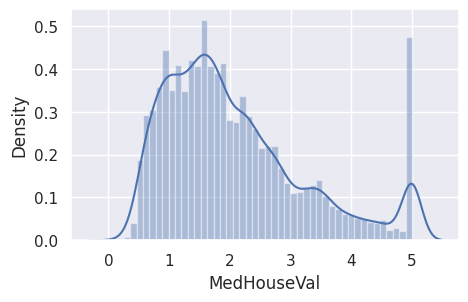

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 


sns.set(rc={'figure.figsize':(5, 3)})
sns.distplot(y)
plt.show()

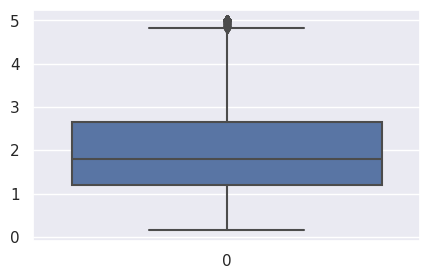

In [19]:
sns.set(rc={'figure.figsize':(5, 3)})
sns.boxplot(y)
plt.show()

 Распределение сильно смещено влево. Есть выбросы целевой переменной при значениях y = 5

# 6. Посчитайте и выведите корреляционную матрицу

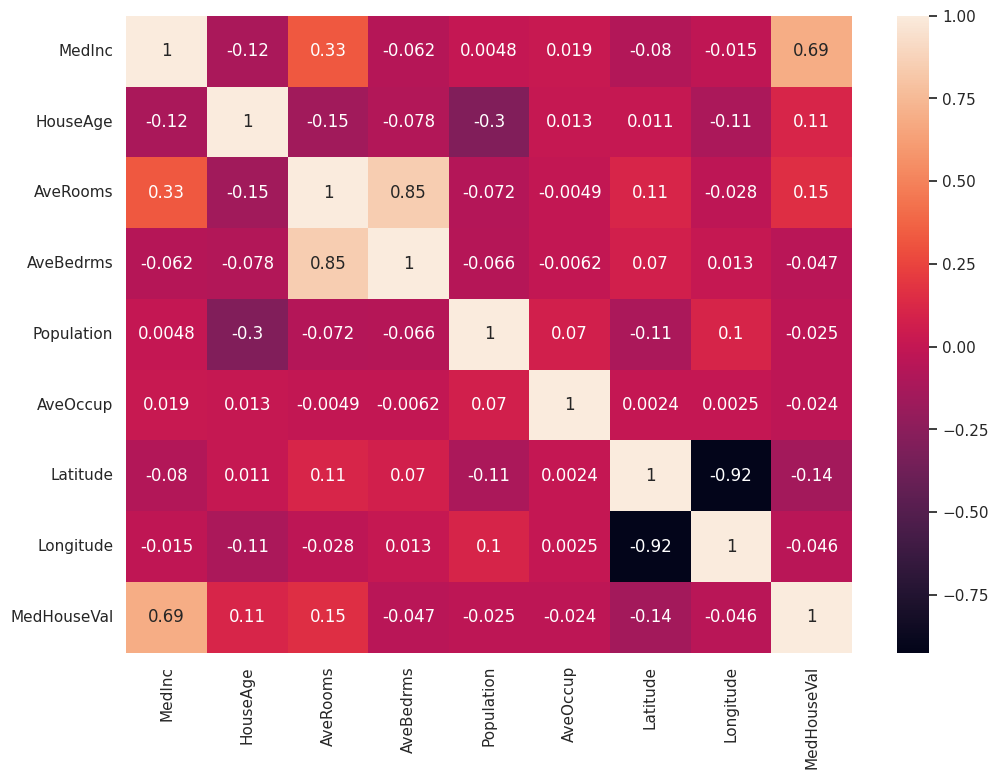

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df.corr(), annot=True)
plt.show()

## a. Сделайте выводы

Изучая корреляцию целевой переменной MedHouseVal и независимых признаков, можно сделать следующие выводы:
1. Сильная положительная связь - только с MedInc. Слабая положительная связь - с AveRooms и HouseAge, слабая отрицательная связь - с Longitude. Все остальные признаки имеют очень низкий к-т корреляции по отношению к MedHouseVal.

2. Сильная положительная корреляция 0.85 между AveBedrms и AveRooms и сильная отрицательная, близкая к -1 связь между Latitude и Longitude ведет к риску коллинеарности этих признаков. 

3. Выявлена слабая положительная корреляция 0.3 между Medinc и AveRooms, слабая отрицательная -0.33 -  между Population и HouseAge.  Все остальные признаки очень слабо коррелируют друг с другом и с целевой переменной. 

На первый взгляд, следует удалять признаки, которые, во-первых, имеют самую слабую корреляцию с целевой переменной и, во-вторых, имеют сильную корреляцию между собой. Кандидаты на удаление - признаки AveOccup, Population и AveBedrms. 
Кроме того, планируется удалить Latitude и Longitude, предварительно проведя кластеризацию  и введя категриальную переменную, которая заменит и широту, и долготу.
ОДнако, прежде чем удалять признаки, проведем дополнительные проверки необходимости такого удаления.

## b. Удалите признаки на основании полученных значений, выводов.

## c. Повторите п. 3, п. 4 на измененных данных.

In [21]:
# Оставить лучшие признаки при помощи SelectKBest , f_regression и GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
pipeline = Pipeline(
    [
     ('selector',SelectKBest(f_regression)),
     ('model',LinearRegression())
    ]
)
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k':[1,2,3,4,5,6,7,8]},
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=3
)
search.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(score_func=<function f_regression at 0x7f462065f5e0>)),
                                       ('model', LinearRegression())]),
             n_jobs=-1, param_grid={'selector__k': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error', verbose=3)

In [22]:
search.best_params_

{'selector__k': 8}

In [23]:
search.best_score_

-0.5582901717686546

Результат - нам предлагается оставить в модели все признаки

In [24]:
def make_mi_scores(X, y, discrete_features):
  """
    Взаимная информация (МИ) между двумя случайными величинами представляет собой 
    неотрицательную величину, которая измеряет зависимость между переменными. 
    Равна нулю тогда и только тогда, когда две случайные величины независимы, 
    а более высокие значения означают более высокую зависимость.

    Функция основана на непараметрических методах оценки энтропии 
    по k-ближайшим соседним расстояниям. 
    Можно использовать для выбора одномерных признаков (sci-kit learn)
  """
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

In [25]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [26]:
X=df.drop(columns=['MedHouseVal'])
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X,y, discrete_features)
mi_scores

Longitude     0.403836
MedInc        0.387852
Latitude      0.369680
AveRooms      0.103361
AveOccup      0.072162
HouseAge      0.032590
AveBedrms     0.023684
Population    0.021041
Name: MI Scores, dtype: float64

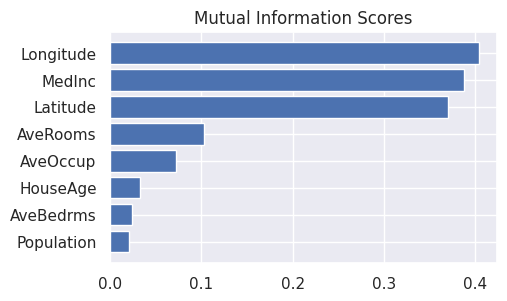

In [27]:
plt.figure(dpi=100, figsize=(5, 3))
plot_mi_scores(mi_scores)

Два кандидата на удаление - AveBedrms и Population. Выполним еще одну проверку: построим модели линейной регрессии и рассчитав метрики R2 и RMSE, поочередно удаляя столбцы из X

In [28]:
def search_cols(X,y, cols, r2, rmse):
    """
    Искренняя благодарность коллеге А. Хрусталеву за идею ф-ии.
    Ф-я принимает на вход вектор признаков, целевую переменную,
    список признаков для проверки и r2и rmse для baseline.
    Поочередно удаляем из вектора  один из признаков, обучаем модель
    линейной регрессии и рассчитываем метрики качества- RMSE и R2
    Возвращаем список словарей, где указано:
    random_state, удаляемая колонка, R2 и RMSE
    """
    r2_test_best=r2
    rmse_test_best=rmse
    best_cols_to_drop = []
    dict_col=dict()

    for col in cols:
      
      tmp_X = X.drop([col], axis=1)
      for i in range(43) :          
        r2_test,rmse_test, coef,intercept = get_score(tmp_X,y, random_seed=i, model=None)
         
        if r2_test > r2_test_best:
            rmse_test_best = rmse_test
            r2_test_best = r2_test
           
            dict_col['random_state'] = i
            dict_col['column'] = col
            dict_col['rmse_test'] = rmse_test
            dict_col['r2_test'] = r2_test
            print(f'random_state: {i}, column:{col}, rmse_test {rmse_test}, r2_test {r2_test} ')
            best_cols_to_drop.append(dict_col)
     
    return  rmse_test_best,r2_test_best,best_cols_to_drop

In [29]:
rmse_test_best, r2_test_best, best_cols_to_drop = search_cols(X,y, feature_names, r2, rmse)

random_state: 5, column:HouseAge, rmse_test 0.7388190966675731, r2_test 0.599566285560887 
random_state: 7, column:HouseAge, rmse_test 0.7305668645997027, r2_test 0.6004676487648952 
random_state: 20, column:HouseAge, rmse_test 0.7322053434227968, r2_test 0.6064427291333337 
random_state: 28, column:HouseAge, rmse_test 0.7204453754927291, r2_test 0.6175166683082413 
random_state: 28, column:AveRooms, rmse_test 0.7197354411613098, r2_test 0.6182701029735023 
random_state: 28, column:Population, rmse_test 0.7122421335572735, r2_test 0.6261772565785643 


In [30]:
r2_test_best # Получается, что для выбранного random_state=42 ничего удалять не надо. Так и поступим

0.6261772565785643

# 7. Исследуйте оставленные признаки на выбросы.

## a. Удалите выбросы в случае обнаружения.

In [31]:
def mahalanobis(x= None , data= None , cov= None ):
  """
  Функция для расчета расстояния Maхаланобиса
  Расстояние Махаланобиса — это расстояние между двумя точками в 
  многомерном пространстве. Оно часто используется для поиска выбросов 
  в статистическом анализе, включающем несколько переменных
  https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9C%D0%B0%D1%85%D0%B0%D0%BB%D0%B0%D0%BD%D0%BE%D0%B1%D0%B8%D1%81%D0%B0
  """
  x_mu = x - np.mean(data)
  if not cov:
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
  return mahal.diagonal()

In [32]:
df['mahalanobis'] = mahalanobis(x=df, data=df[list(df.columns)])
df['p'] = 1 - chi2.cdf(df['mahalanobis'], 3)

#Обычно выбросом считается p-значение меньше 0,001
tmp=df[df['p']>0.001]
tmp.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,mahalanobis,p
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,9.481103,0.023533
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,9.688851,0.021405
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,11.169189,0.010845
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,6.326904,0.096745
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,8.250569,0.041107


In [33]:
tmp.shape

(19469, 11)

In [34]:
a=list(tmp.columns)
a.remove('mahalanobis')
a.remove('p')

In [35]:
df=tmp.loc[:, a]
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [36]:
X=df.drop(columns=['MedHouseVal'])
y=df['MedHouseVal']

## b. Повторите п. 3, п. 4 на измененных данных.

In [37]:
r2_1, rmse_1, coef_1, intercept_1 = get_score(X, y, random_seed=42, model=None)
print('Изменения в метриках качества после удаления выбросов')
print(f'R2 = {r2_1}, RMSE = {rmse_1}')
print(f'Изменения в метриках:R2 увеличилась на {(r2_1-r2)/r2*100.}%, RMSE уменьшилась на {(rmse_1 - rmse)/rmse * 100.}%')

Изменения в метриках качества после удаления выбросов
R2 = 0.6960762136542791, RMSE = 0.6069678518839074
Изменения в метриках:R2 увеличилась на 16.836353271516998%, RMSE уменьшилась на -16.671176190445518%


In [38]:
stage = 'Удаление выбросов'

In [39]:
results.loc[len(results.index)] = [stage,r2_1, rmse_1, list(X.columns), '', intercept_1, coef_1]

In [40]:
results.head()

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."


# 8. Измените несколько признаков на выбор математически. Например, вычислите логарифм, возведите в квадрат, извлеките квадратный корень.

## a. Повторите п. 3, п. 4 на измененных данных.

In [41]:
def transform_cols(X,y, cols,rmse_test_best,r2_test_best, random_seed):
  """
  Функция исследует влияние трансформации признаков на метрики качества линейной регрессии

  """
  transformations=[]
  
  methods = ['sqrt','log', 'lod1p', 'power2', 'power3', 'power4', 'power5']
  
  for col in cols:
    transformation = dict() 
    rmse_test_best = 0
    r2_test_best = 0
    for method in methods:
      tmp_X = X.copy()
      if method == 'sqrt' :
        tmp_X[col]=np.sqrt(abs(tmp_X[col]))
      elif method=='log' :
        tmp_X[col] = (abs(tmp_X[col])+1).transform(np.log)
      elif method == 'log1p' :
        tmp_X[col] = (abs(tmp_X[col])+1).transform(np.log1p)
      elif method == 'power2' :
        tmp_X[col]= tmp_X[col]**2
      elif method == 'power3':
        tmp_X[col]= tmp_X[col]**3
      elif method == 'power4' :  
        tmp_X[col]= tmp_X[col]**4
    
      r2_test, rmse_test, coef,intercept = get_score(tmp_X,y, random_seed=random_seed, model=None)  
      # print(f'{method}:{col}: r2_test {r2_test} rmse_test {rmse_test}')              
      if rmse_test< rmse_test_best or r2_test > r2_test_best:
          rmse_test_best = rmse_test
          r2_test_best = r2_test
         
          transformation['method'] = method
          transformation['column'] = col
          transformation['r2'] = r2_test_best
          transformation['rmse'] = rmse_test_best

    transformations.append(transformation)
 
  return transformations

In [42]:
tmp=df.copy()
y=tmp['MedHouseVal']
X=tmp.drop(columns=['MedHouseVal'])
cols=list(X.columns)

In [43]:
cols

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

посмотрим на изменения в метриках качества модели при различных трансформациях колонок

In [44]:
transformations = transform_cols(X,y, cols,rmse_1,r2_1, 42)

In [45]:
transformations # показывает лучший вариант трансформации для каждого столбца при условии, что транформации подвергается только этот столбец

[{'method': 'lod1p',
  'column': 'MedInc',
  'r2': 0.6960762136542791,
  'rmse': 0.6069678518839074},
 {'method': 'lod1p',
  'column': 'HouseAge',
  'r2': 0.6960762136542791,
  'rmse': 0.6069678518839074},
 {'method': 'log',
  'column': 'AveRooms',
  'r2': 0.6976669104802437,
  'rmse': 0.605377373410432},
 {'method': 'log',
  'column': 'AveBedrms',
  'r2': 0.6971803072632001,
  'rmse': 0.6058643530900153},
 {'method': 'sqrt',
  'column': 'Population',
  'r2': 0.6961371507369013,
  'rmse': 0.6069069999434477},
 {'method': 'log',
  'column': 'AveOccup',
  'r2': 0.7080887874511884,
  'rmse': 0.5948517343236779},
 {'method': 'log',
  'column': 'Latitude',
  'r2': 0.6963434539825413,
  'rmse': 0.6067009396381857},
 {'method': 'log',
  'column': 'Longitude',
  'r2': 0.6962464397427635,
  'rmse': 0.6067978483510328}]

Базовые метрики после удаления выбросов: R2 = 0.6960762136542791, RMSE = 0.6069678518839074

Планируется, что при трансформации следующих признаков будет достигнуто улучшение:  
*    Population(0.6961371507369013)
*    Longitude (0.6962464397427635)
*    Latitude (0.6963434539825413)
*    AveBedrms (0.6971803072632001)
*    AveRooms (0.6976669104802437)
*    AveOccup (0.7080887874511884)


In [46]:
y=tmp['MedHouseVal']
X=tmp.drop(columns=['MedHouseVal'])

In [47]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Трансформируем Population

In [48]:
X_tmp=X.copy()
X_tmp['Population']=np.sqrt(X_tmp['Population'])
r2_2, rmse_2, coef_2, intercept_2 = get_score(X_tmp,y, random_seed=42, model=None)
print(f'R2 = {r2_2}, RMSE = {rmse_2}')
print(f'Изменения в метриках:R2 - на {(r2_2-r2_1)/r2_1*100.}%, RMSE - на {(rmse_2 - rmse_1)/rmse_1 * 100.}%')

R2 = 0.6961371507369013, RMSE = 0.6069069999434477
Изменения в метриках:R2 - на 0.008754369338713134%, RMSE - на -0.010025562354072249%


In [49]:
stage = 'Трансформация Population'
results.loc[len(results.index)] = [stage,r2_2, rmse_2, list(X.columns), 'sqrt', intercept_2, coef_2]

In [50]:
results.head()

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."


Трансформируем Longitude

In [51]:
X=X_tmp.copy()
X_tmp=X.copy()
X_tmp['Longitude']=(abs(X_tmp['Longitude'])+1).transform(np.log)
r2_3, rmse_3, coef_3, intercept_3 = get_score(X_tmp,y, random_seed=42, model=None)
print(f'R2 = {r2_3}, RMSE = {rmse_3}')
print(f'Изменения в метриках:R2 - на {(r2_3-r2_2)/r2_2*100.}%, RMSE - на {(rmse_3 - rmse_2)/rmse_2 * 100.}%')

R2 = 0.6963048003102561, RMSE = 0.6067395531200137
Изменения в метриках:R2 - на 0.024082836719363888%, RMSE - на -0.027590194782652133%


In [52]:
stage = 'Трансформация Longitude'
results.loc[len(results.index)] = [stage,r2_3, rmse_3, list(X.columns), 'log', intercept_3, coef_3]
results.head()

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."
3,Трансформация Longitude,0.696305,0.606740,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8622785454635296, 0.14692950795437418, -0.2..."


Трансформируем Latitude

In [53]:
X=X_tmp.copy()
X_tmp=X.copy()
X_tmp['Latitude']=(abs(X_tmp['Latitude'])+1).transform(np.log)
r2_4, rmse_4, coef_4, intercept_4 = get_score(X_tmp,y, random_seed=42, model=None)
print(f'R2 = {r2_4}, RMSE = {rmse_4}')
print(f'Изменения в метриках:R2 - на {(r2_4-r2_3)/r2_3*100.}%, RMSE - на {(rmse_4 - rmse_3)/rmse_3 * 100.}%')

R2 = 0.6966659451480033, RMSE = 0.6063786879509718
Изменения в метриках:R2 - на 0.05186591239731044%, RMSE - на -0.059476124011730636%


In [54]:
stage = 'Трансформация Latitude'
results.loc[len(results.index)] = [stage,r2_4, rmse_4, list(X.columns), 'log', intercept_4, coef_4]
results.head()

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."
3,Трансформация Longitude,0.696305,0.606740,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8622785454635296, 0.14692950795437418, -0.2..."
4,Трансформация Latitude,0.696666,0.606379,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8631971926201976, 0.1480929493476086, -0.20..."


Трансформируем AveBedrms

In [55]:
X=X_tmp.copy()
X_tmp=X.copy()
X_tmp['AveBedrms']=(abs(X_tmp['AveBedrms'])+1).transform(np.log)
r2_5, rmse_5, coef_5,intercept_5 = get_score(X_tmp,y, random_seed=42, model=None)
print(f'R2 = {r2_5}, RMSE = {rmse_5}')
print(f'Изменения в метриках:R2 - на {(r2_5-r2_4)/r2_4*100.}%, RMSE - на {(rmse_5 - rmse_4)/rmse_4 * 100.}%')

R2 = 0.6977221598387253, RMSE = 0.6053220565416202
Изменения в метриках:R2 - на 0.1516099212367338%, RMSE - на -0.1742527285914559%


In [56]:
stage = 'Трансформация AveBedrms'
results.loc[len(results.index)] = [stage,r2_5, rmse_5, list(X.columns), 'log', intercept_5, coef_5]
results.head()

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."
3,Трансформация Longitude,0.696305,0.606740,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8622785454635296, 0.14692950795437418, -0.2..."
4,Трансформация Latitude,0.696666,0.606379,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8631971926201976, 0.1480929493476086, -0.20..."


Трансформируем AveRooms

In [57]:
X=X_tmp.copy()
X_tmp=X.copy()
X_tmp['AveRooms']=(abs(X_tmp['AveRooms'])+1).transform(np.log)
r2_6, rmse_6, coef_6,intercept_6 = get_score(X_tmp,y, random_seed=42, model=None)
print(f'R2 = {r2_6}, RMSE = {rmse_6}')
print(f'Изменения в метриках:R2 - на {(r2_6-r2_5)/r2_5*100.}%, RMSE - на {(rmse_6 - rmse_5)/rmse_5 * 100.}%')

R2 = 0.69956115327279, RMSE = 0.6034779227659889
Изменения в метриках:R2 - на 0.2635710229541452%, RMSE - на -0.3046533255648036%


In [58]:
stage = 'Трансформация AveRooms'
results.loc[len(results.index)] = [stage,r2_6, rmse_6, list(X.columns), 'log', intercept_6, coef_6]
results.head(6)

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."
3,Трансформация Longitude,0.696305,0.606740,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8622785454635296, 0.14692950795437418, -0.2..."
4,Трансформация Latitude,0.696666,0.606379,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8631971926201976, 0.1480929493476086, -0.20..."
5,Трансформация AveBedrms,0.697722,0.605322,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8672331026398157, 0.14882951256861998, -0.2..."


Трансформируем AveOccup

In [59]:
X=X_tmp.copy()
X_tmp=X.copy()
X_tmp['AveOccup']=(abs(X_tmp['AveOccup'])+1).transform(np.log)
r2_7, rmse_7, coef_7,intercept_7 = get_score(X_tmp,y, random_seed=42, model=None)
print(f'R2 = {r2_7}, RMSE = {rmse_7}')
print(f'Изменения в метриках:R2 - на {(r2_7-r2_6)/r2_6*100.}%, RMSE - на {(rmse_7 - rmse_6)/rmse_6 * 100.}%')

R2 = 0.7114461930211629, RMSE = 0.5914210090487815
Изменения в метриках:R2 - на 1.6989279197065912%, RMSE - на -1.9979046891965138%


In [60]:
stage = 'Трансформация AveOccup'
results.loc[len(results.index)] = [stage,r2_7, rmse_7, list(X.columns), 'log', intercept_7, coef_7]
results.head(7)

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."
3,Трансформация Longitude,0.696305,0.606740,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8622785454635296, 0.14692950795437418, -0.2..."
4,Трансформация Latitude,0.696666,0.606379,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8631971926201976, 0.1480929493476086, -0.20..."
5,Трансформация AveBedrms,0.697722,0.605322,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8672331026398157, 0.14882951256861998, -0.2..."
6,Трансформация AveRooms,0.699561,0.603478,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8659803050254057, 0.14986392148303274, -0.2..."


In [61]:
X=X_tmp.copy()
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,2.077455,0.704982,17.944358,1.268511,3.660480,4.814053
1,8.3014,21.0,1.979364,0.678988,49.000000,1.134572,3.659965,4.813971
2,7.2574,52.0,2.228738,0.729212,22.271057,1.335596,3.659708,4.814134
3,5.6431,52.0,1.919471,0.729025,23.622024,1.266369,3.659708,4.814215
4,3.8462,52.0,1.985385,0.732888,23.769729,1.157342,3.659708,4.814215


In [62]:
df=pd.concat([X,y],axis=1) # X и y

In [63]:
tmp=df.copy()

In [64]:
print('Вывод: После трансформации признаков достигнуты следующие результаты по сравнению с метриками после удаления  выбросов:')
print(f'Было: R2 = {r2_1}, RMSE = {rmse_1}')
print(f'Стало: R2 = {r2_7}, RMSE = {rmse_7}')
print(f'Изменения в метриках:R2 - на {(r2_7-r2_1)/r2_1*100.}%, RMSE - на {(rmse_7 - rmse_1)/rmse_1 * 100.}%')

Вывод: После трансформации признаков достигнуты следующие результаты по сравнению с метриками после удаления  выбросов:
Было: R2 = 0.6960762136542791, RMSE = 0.6069678518839074
Стало: R2 = 0.7114461930211629, RMSE = 0.5914210090487815
Изменения в метриках:R2 - на 2.208088577857597%, RMSE - на -2.5613947735241114%


Посмотрим, как выглядят распределения признаков после преобразований

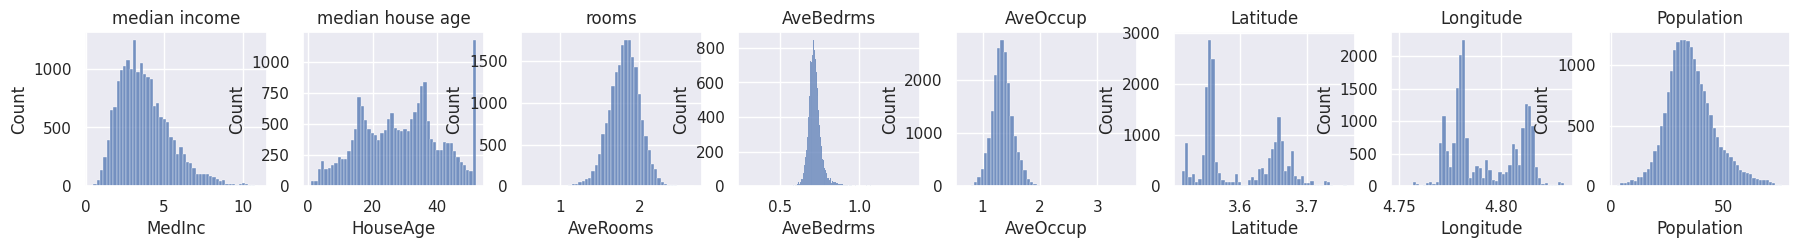

In [65]:
f, ax = plt.subplots(nrows=1, ncols=8, figsize=(22,2))

_ = sns.histplot(x=X['MedInc'], bins=50, ax=ax[0])
ax[0].set_title('median income')
_ = sns.histplot(x=X['HouseAge'], bins=50, ax=ax[1])
ax[1].set_title('median house age')
_ = sns.histplot(x=X['AveRooms'], bins=50,ax=ax[2])
ax[2].set_title('rooms')
_ = sns.histplot(x=X['AveBedrms'], ax=ax[3])
ax[3].set_title('AveBedrms')
_ = sns.histplot(x=X['AveOccup'], bins=50,ax=ax[4])
ax[4].set_title( 'AveOccup')
_ = sns.histplot(x=X['Latitude'], bins=50,ax=ax[5])
ax[5].set_title( 'Latitude')
_ = sns.histplot(x=X['Longitude'], bins=50,ax=ax[6])
ax[6].set_title( 'Longitude')
_ = sns.histplot(x=X['Population'], bins=50,ax=ax[7])
ax[7].set_title( 'Population')
plt.show()
plt.close()

Проведем кластеризацию

In [66]:
y=tmp['MedHouseVal']
X=tmp.drop(columns=['MedHouseVal'])

In [67]:
X_tmp = X.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tmp)

In [68]:
# оптимальное к-во кластеров неизвестно. Будем выбирать, исходя из метрик качества модели
r2_best= r2_7
rmse_best=rmse_7
clastering=dict()
# Может, дальше еще лучше будет, но не хочется сильно увеличивать к-во признаков
for i in range(4,380):
  kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
  cluster = kmeans.fit_predict(X_scaled)
  tmp = df.copy()
  tmp['cluster'] = cluster
  tmp=get_one_hot(tmp, ['cluster'])
  X_tmp=tmp.drop(columns=['MedHouseVal'])
  r2_test, rmse_test, coef,intercept = get_score(X_tmp,y, random_seed=42, model=None)
  if rmse_test< rmse_best or r2_test > r2_best:
    rmse_best = rmse_test
    r2_best = r2_test
    clastering['n'] =i    
    clastering['r2'] = r2_best
    clastering['rmse'] = rmse_best
# Считаем 14 минут

In [69]:
clastering

{'n': 285, 'r2': 0.7567036673701303, 'rmse': 0.5340742474151743}

In [70]:
kmeans = KMeans(n_clusters=285,random_state=42, n_init='auto')
cluster = kmeans.fit_predict(X_scaled)
tmp = df.copy()
tmp['cluster'] = cluster
tmp=get_one_hot(tmp, ['cluster'])
X_tmp=tmp.drop(columns=['MedHouseVal'])
r2_8, rmse_8, coef_8,intercept_8 = get_score(X_tmp,y, random_seed=42, model=None)
print(f'R2 = {r2_8}, RMSE = {rmse_8}')
print(f'Изменения в метриках:R2 - на {(r2_8-r2_7)/r2_7*100.}%, RMSE - на {(rmse_8 - rmse_7)/rmse_7 * 100.}%')

R2 = 0.7570439161383953, RMSE = 0.5337006666046429
Изменения в метриках:R2 - на 6.409159760009577%, RMSE - на -9.759602983494576%


In [ ]:
stage = 'Кластеризация'
results.loc[len(results.index)] = [stage,r2_8, rmse_8, list(X.columns), '', intercept_8, coef_8]

In [75]:

results.head(9)

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."
3,Трансформация Longitude,0.696305,0.606740,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8622785454635296, 0.14692950795437418, -0.2..."
4,Трансформация Latitude,0.696666,0.606379,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8631971926201976, 0.1480929493476086, -0.20..."
5,Трансформация AveBedrms,0.697722,0.605322,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8672331026398157, 0.14882951256861998, -0.2..."
6,Трансформация AveRooms,0.699561,0.603478,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8659803050254057, 0.14986392148303274, -0.2..."
7,Трансформация AveOccup,0.711446,0.591421,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8487837349558816, 0.1533765394554204, -0.19..."
8,Кластеризация,0.757044,0.533701,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011311,"[0.6412779782040239, 0.11544239626631297, -0.0..."


In [72]:
tmp.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,cluster,...,cluster_275,cluster_276,cluster_277,cluster_278,cluster_279,cluster_280,cluster_281,cluster_282,cluster_283,cluster_284
0,8.3252,41.0,2.077455,0.704982,17.944358,1.268511,3.660480,4.814053,4.526,152,...,0,0,0,0,0,0,0,0,0,0
1,8.3014,21.0,1.979364,0.678988,49.000000,1.134572,3.659965,4.813971,3.585,27,...,0,0,0,0,0,0,0,0,0,0
2,7.2574,52.0,2.228738,0.729212,22.271057,1.335596,3.659708,4.814134,3.521,14,...,0,0,0,0,0,0,0,0,0,0
3,5.6431,52.0,1.919471,0.729025,23.622024,1.266369,3.659708,4.814215,3.413,172,...,0,0,0,0,0,0,0,0,0,0
4,3.8462,52.0,1.985385,0.732888,23.769729,1.157342,3.659708,4.814215,3.422,133,...,0,0,0,0,0,0,0,0,0,0


# 9. Сформулируйте выводы по проделанной работе.

## a. Кратко опишите какие преобразования были сделаны с данными.

В процессе работы  с данными были выполнены следующие преобразования:
*   Удаление выбросов при помощи расстояния Махаланобиса
*   Трансформация признаков :
        * Population(sqrt)
        * Longitude (log)
        * Latitude (log)
        * AveBedrms (log)
        * AveRooms (log)
        * AveOccup (log)
*    Масштабирование численных признаков при помощт StandardScaler    
*    Кластеризация и последующая трансфорация нового признака cluster при помощи OneHotEncoder    

## b. Сравните метрики всех моделей. Желательно оформление в виде таблицы вида |модель|RMSE|R2|признаки, на которых проводилось обучение с указанием их преобразований|

In [76]:
results.head(9)

,stage,R2,RMSE,Features,Transformations,Intercept,Coef
0,BaseLine,0.595770,0.728401,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.069240,"[0.8492217601003719, 0.12211930906462487, -0.2..."
1,Удаление выбросов,0.696076,0.606968,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011034,"[0.862958451803064, 0.1479600847365695, -0.210..."
2,Трансформация Population,0.696137,0.606907,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",sqrt,2.011034,"[0.8631979173799593, 0.14731565108560313, -0.2..."
3,Трансформация Longitude,0.696305,0.606740,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8622785454635296, 0.14692950795437418, -0.2..."
4,Трансформация Latitude,0.696666,0.606379,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8631971926201976, 0.1480929493476086, -0.20..."
5,Трансформация AveBedrms,0.697722,0.605322,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8672331026398157, 0.14882951256861998, -0.2..."
6,Трансформация AveRooms,0.699561,0.603478,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8659803050254057, 0.14986392148303274, -0.2..."
7,Трансформация AveOccup,0.711446,0.591421,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",log,2.011034,"[0.8487837349558816, 0.1533765394554204, -0.19..."
8,Кластеризация,0.757044,0.533701,"[MedInc, HouseAge, AveRooms, AveBedrms, Popula...",,2.011311,"[0.6412779782040239, 0.11544239626631297, -0.0..."


## c. Напишите свое мнение, в полной ли мере модели справились с поставленной задачей

Работа с призаками дала неплохие результаты - качество модели по сравнению с BaseLine существенно возросло.
В то же время, несмотря на все усилия, по-настоящему хороших метрик качества модели достигнуть не удалось. Это связано, во-первых, с типом выбранной модели (вполне вероятно, што надругих видах регрессоров качество повысится) и, во-вторых, с тем, что зависимость целевой переменной от множества признаков - не совсем линейная.